In [1]:
%matplotlib inline

import sys
sys.path.append("..")

from src.regime_trading_pipeline import RegimeRotationStrategy
from src.performance_toolkit import RegimePerformanceToolkit

## Fit WK-means Model and Build Returns

In [2]:
growth = [
    "IWP",   # iShares Russell Mid-Cap Growth ETF
    "IWY",   # iShares Russell Top 200 Growth ETF
    "QUAL",  # iShares MSCI USA Quality Factor ETF
    "QQQ",   # Invesco QQQ Trust (Nasdaq-100)
    "RPG",   # Invesco S&P 500 Pure Growth ETF
    "SCHG",  # Schwab U.S. Large-Cap Growth ETF
    "SCHM",  # Schwab U.S. Mid-Cap ETF
    "VBK",   # Vanguard Small-Cap Growth ETF
    "VGT",   # Vanguard Information Technology Index Fund ETF
    "VUG",   # Vanguard Growth ETF
]

# Retrieved from https://www.simplysafedividends.com/world-of-dividends/posts/939-20-best-recession-proof-dividend-stocks-for-a-2025-downturn
defensive = [
    "BMY",  # Bristol-Myers Squibb Co. (pharmaceuticals)
    "CL",   # Colgate-Palmolive Co. (consumer staples – personal care)
    "CVX",  # Chevron Corp. (integrated oil & gas)
    "DUK",  # Duke Energy Corp. (regulated electric utility)
    "ED",   # Consolidated Edison, Inc. (regulated utility)
    "EPD",  # Enterprise Products Partners L.P. (midstream energy MLP)
    "GIS",  # General Mills, Inc. (packaged foods)
    "GPC",  # Genuine Parts Co. (industrial/auto parts distributor)
    "JNJ",  # Johnson & Johnson (healthcare & consumer health)
    "KMB",  # Kimberly-Clark Corp. (tissue & hygiene products)
    "KO",   # Coca-Cola Co. (beverages)
    "LMT",  # Lockheed Martin Corp. (defense & aerospace)
    "MCD",  # McDonald's Corp. (global quick-service restaurants)
    "O",    # Realty Income Corp. (net-lease REIT, “monthly dividend”)
    "PEP",  # PepsiCo, Inc. (snacks & beverages)
    "PG",   # Procter & Gamble Co. (household & personal products)
    "PSA",  # Public Storage (self-storage REIT)
    "VZ",   # Verizon Communications Inc. (telecom)
    "WEC",  # WEC Energy Group, Inc. (regulated utility)
    "XOM",  # Exxon Mobil Corp. (integrated oil & gas)
]

gold = ["GLD"]

strategy = RegimeRotationStrategy(
    growth_tickers=growth,
    defensive_tickers=defensive,
    extra_legs={"gold": gold},
    start_date="2019-05-09",  # 5 yrs data (post covid)
    p_dim=2,                  # W2 distance
    window=360,               # approx. 15 days hourly return
    step=12,                  # half a day
    refit_every=96,           # refit MK-means every 48 days
    shift=True,               # avoid using future information
    use_log=True,             # using log returns
    # max_label_gap=10,         # smoothing transient gap between regimes
)

strategy.fit_kmeans()
strategy.build_returns()

## Backtest

### Aggressive Strategy

In [3]:
aggressive = strategy.backtest(
    allocations={
        0: {"growth": 1.0, "defensive": 0.0},
        1: {"growth": 0.5, "defensive": 0.5},
        2: {"growth": 0.0, "defensive": 1.0},
    },
)

toolkit = RegimePerformanceToolkit(aggressive)
toolkit.show_basic_info()

Start date: 2020-10-30
End date:   2025-10-30
Duration:   1826 

# of points in cluster 0 : 679
# of points in cluster 1 : 361
# of points in cluster 2 : 216


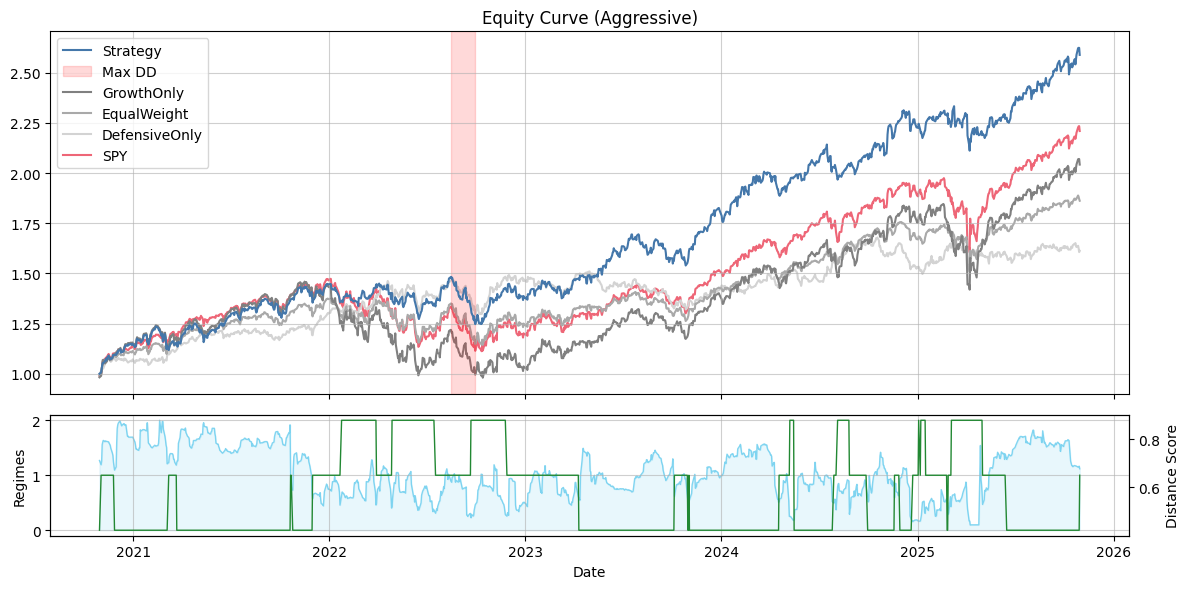

In [4]:
toolkit.plot_equity_curves("Aggressive")

In [5]:
toolkit.summary_table()

,cumulative_return,annual_return,annual_vol,sharpe,sortino,max_drawdown,hit_rate,avg_up_day,avg_down_day,skew,kurtosis
Strategy,158.9400%,21.0512%,14.9005%,1.412781,1.976806,-15.8992%,55.8566%,0.7137%,-0.7212%,-0.420317,1.300687
GrowthOnly,107.9717%,15.8389%,21.1850%,0.747645,1.045444,-32.8144%,53.8645%,0.9573%,-0.9719%,0.139034,5.424290
EqualWeight,88.0620%,13.5217%,13.9944%,0.966221,1.339096,-16.7465%,54.1833%,0.6333%,-0.6306%,0.003423,5.620455
DefensiveOnly,61.5923%,10.1159%,12.1861%,0.830121,1.208394,-12.5564%,53.8645%,0.5756%,-0.5827%,-0.213222,1.976311
SPY,123.3194%,17.5069%,17.1587%,1.020292,1.405234,-24.4964%,54.6614%,0.7634%,-0.7690%,0.289323,9.009560


In [6]:
toolkit.average_holding_period()

,avg,min,max,count
holding_periods,,,,
"G=1.0, D=0.0, G=0.0",56.58,1,148,12
"G=0.5, D=0.5, G=0.0",20.00,1,91,18
"G=0.0, D=1.0, G=0.0",27.00,1,54,8


In [7]:
toolkit.monthly_returns_table()

month,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,YTD
year,,,,,,,,,,,,,
2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.3778%,5.0948%,14.9504%
2021,-0.3734%,1.7573%,0.0789%,5.6686%,-1.0908%,5.5025%,2.4709%,3.4631%,-5.2414%,7.8226%,-0.7059%,4.4947%,25.7364%
2022,-4.0732%,-0.7623%,3.9653%,-4.8451%,2.0365%,-2.6071%,5.7179%,-3.2722%,-9.8216%,10.2783%,5.1566%,-4.4566%,-4.3800%
2023,4.1891%,-2.1117%,3.8118%,1.8808%,2.4835%,7.0467%,3.6624%,-1.8797%,-5.3219%,-0.8454%,9.7157%,5.9501%,31.3505%
2024,1.0917%,6.6103%,2.3802%,-4.6368%,3.0173%,4.3277%,-0.5741%,0.5331%,2.1010%,-0.3393%,8.4422%,-1.6060%,22.7300%
2025,1.5899%,0.3751%,1.2321%,-3.9272%,2.3635%,3.9562%,2.6614%,1.5595%,3.5180%,2.0381%,NaN,NaN,16.2243%


In [8]:
toolkit.drawdown_table(top_n=5)

,start,trough,recovery,depth,time_to_trough,recovery_days,duration
rank,,,,,,,
34,2022-08-17,2022-09-30,2023-04-13,-15.8992%,44,195.0,239.0
32,2022-04-05,2022-06-17,2022-08-10,-12.2002%,73,54.0,127.0
16,2021-02-16,2021-03-08,2021-04-15,-9.5095%,20,38.0,58.0
75,2025-03-11,2025-04-08,2025-06-27,-9.5020%,28,80.0,108.0
48,2023-08-01,2023-10-27,2023-11-20,-9.1840%,87,24.0,111.0


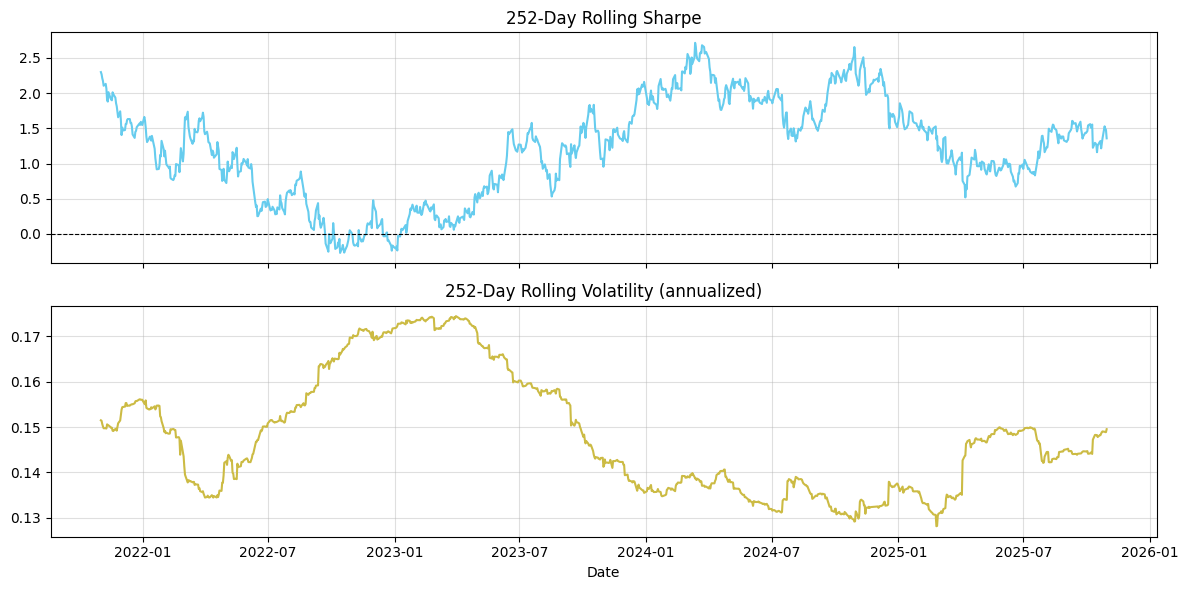

In [9]:
toolkit.plot_rolling_metrics(252)

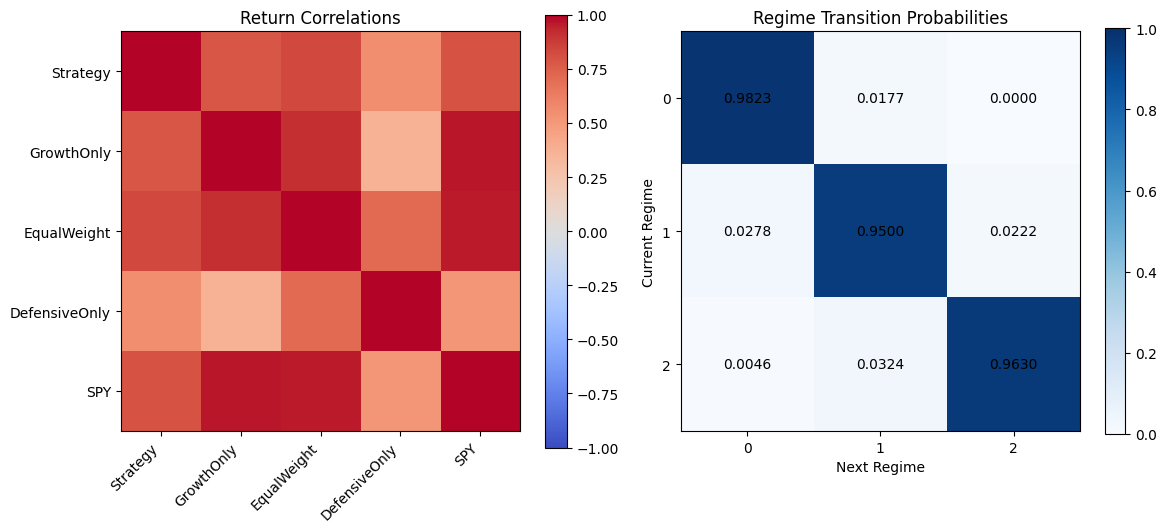

In [10]:
toolkit.plot_correlation_and_transitions()

### Conservative Strategy

In [11]:
conservative = strategy.backtest(
    allocations={
        0: {"growth": 1.0, "defensive": 0.0},
        1: {"growth": 0.0, "defensive": 1.0},
        2: {"growth": 0.0, "defensive": 0.7, "gold": 0.3},
    },
)

toolkit = RegimePerformanceToolkit(conservative)
toolkit.show_basic_info()

Start date: 2020-10-30
End date:   2025-10-30
Duration:   1826 

# of points in cluster 0 : 679
# of points in cluster 1 : 361
# of points in cluster 2 : 216


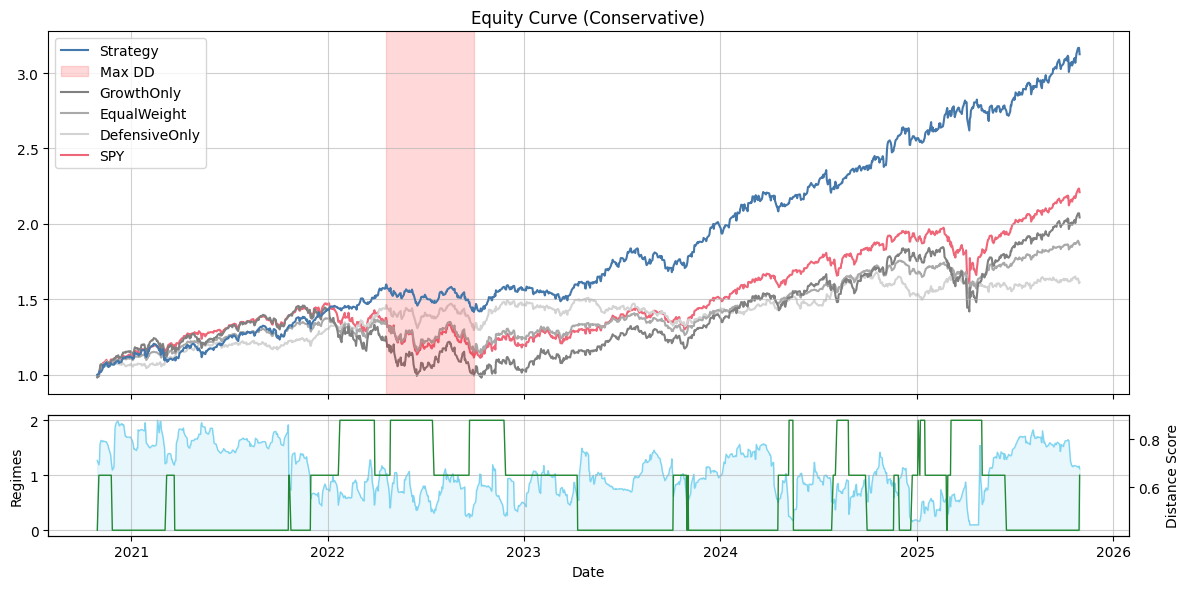

In [12]:
toolkit.plot_equity_curves("Conservative")

In [13]:
toolkit.summary_table()

,cumulative_return,annual_return,annual_vol,sharpe,sortino,max_drawdown,hit_rate,avg_up_day,avg_down_day,skew,kurtosis
Strategy,212.4797%,25.7068%,13.8740%,1.852867,2.601145,-11.4230%,56.4143%,0.6765%,-0.6584%,-0.398804,1.352146
GrowthOnly,107.9717%,15.8389%,21.1850%,0.747645,1.045444,-32.8144%,53.8645%,0.9573%,-0.9719%,0.139034,5.424290
EqualWeight,88.0620%,13.5217%,13.9944%,0.966221,1.339096,-16.7465%,54.1833%,0.6333%,-0.6306%,0.003423,5.620455
DefensiveOnly,61.5923%,10.1159%,12.1861%,0.830121,1.208394,-12.5564%,53.8645%,0.5756%,-0.5827%,-0.213222,1.976311
SPY,123.3194%,17.5069%,17.1587%,1.020292,1.405234,-24.4964%,54.6614%,0.7634%,-0.7690%,0.289323,9.009560


In [14]:
toolkit.average_holding_period()

,avg,min,max,count
holding_periods,,,,
"G=1.0, D=0.0, G=0.0",56.58,1,148,12
"G=0.0, D=1.0, G=0.0",20.00,1,91,18
"G=0.0, D=0.7, G=0.3",27.00,1,54,8


In [15]:
toolkit.monthly_returns_table()

month,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,YTD
year,,,,,,,,,,,,,
2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.6969%,5.0948%,12.1329%
2021,-0.3734%,1.7573%,-1.0704%,5.6686%,-1.0908%,5.5025%,2.4709%,3.4631%,-5.2414%,7.8258%,-0.7059%,7.1295%,27.4301%
2022,1.1034%,1.2808%,3.1440%,2.2213%,0.4495%,-2.2609%,2.1062%,-2.2100%,-6.3628%,6.5511%,5.4431%,-1.6254%,9.5338%
2023,-0.4425%,-2.7023%,3.0744%,3.4223%,2.4835%,7.0467%,3.6624%,-1.8797%,-5.3219%,1.2979%,9.1317%,5.9501%,27.7765%
2024,1.0917%,6.6103%,2.3802%,-4.0986%,2.2629%,4.3277%,-1.2569%,5.4224%,1.5280%,-0.3393%,8.6947%,-0.6654%,28.3901%
2025,1.7246%,4.4703%,3.2957%,-1.1243%,-0.2526%,2.0675%,2.6614%,1.5595%,3.5180%,2.0381%,NaN,NaN,21.6987%


In [16]:
toolkit.drawdown_table(top_n=5)

,start,trough,recovery,depth,time_to_trough,recovery_days,duration
rank,,,,,,,
38,2022-04-21,2022-09-30,2023-04-06,-11.4230%,162,188.0,350.0
13,2021-02-16,2021-03-09,2021-04-26,-9.9566%,21,48.0,69.0
54,2023-08-01,2023-10-03,2023-11-14,-8.6106%,63,42.0,105.0
14,2021-04-27,2021-05-12,2021-06-21,-7.5223%,15,40.0,55.0
91,2025-04-01,2025-04-08,2025-04-22,-7.0683%,7,14.0,21.0


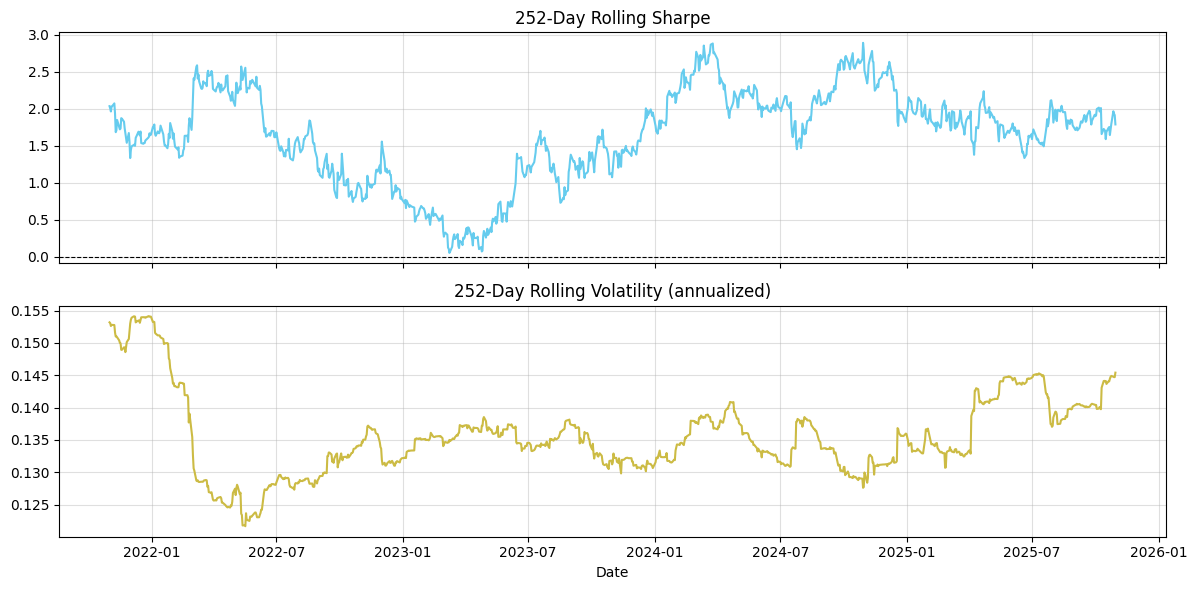

In [17]:
toolkit.plot_rolling_metrics(252)

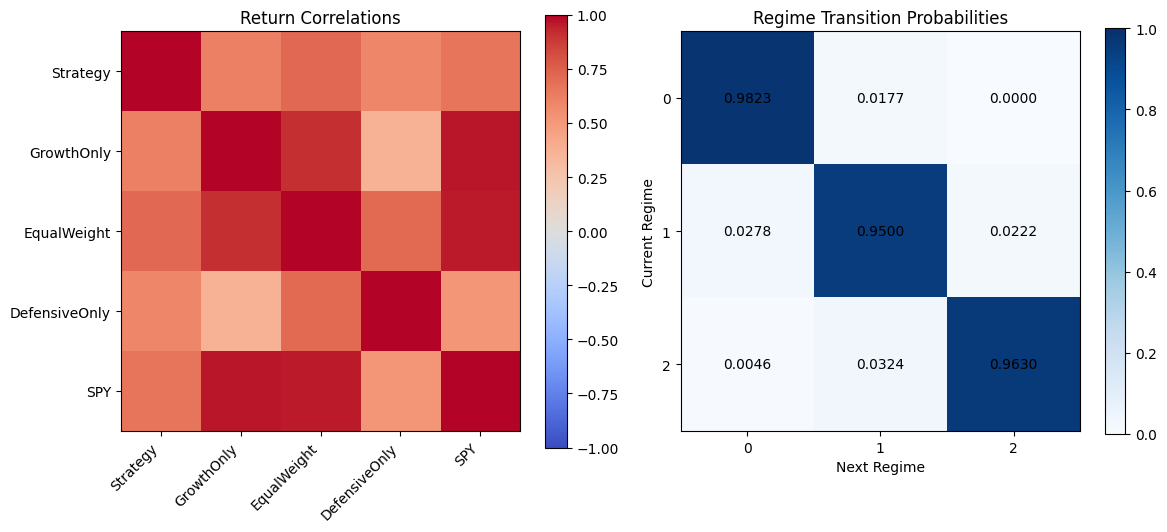

In [18]:
toolkit.plot_correlation_and_transitions()

## Grid Search for Hyperparameter Tunning

In [19]:
df = RegimeRotationStrategy.grid_search_regimes(
    growth,
    defensive,
    start_date="2019-05-09",
    windows=(36, 72, 120, 240, 360, 480),
    steps=(6, 12, 24, 48),
    refits=(12, 24, 48, 96, 120),
)
df

Output()

start_date    end_date  duration  \
p window step refit_every burn_in                                     
2 360    12   120         700      2020-10-30  2025-10-30      1826   
              96          700      2020-10-30  2025-10-30      1826   
              48          700      2020-10-30  2025-10-30      1826   
              12          700      2020-10-30  2025-10-30      1826   
              24          700      2020-10-30  2025-10-30      1826   
...                                       ...         ...       ...   
         48   120         700      2025-02-05  2025-10-30       267   
              12          700      2025-02-05  2025-10-30       267   
              24          700      2025-02-05  2025-10-30       267   
              48          700      2025-02-05  2025-10-30       267   
              96          700      2025-02-05  2025-10-30       267   

                                   cumulative_return  annual_return  \
p window step refit_every burn_in                                     
2 360    12   120         700               2.170658       0.260518   
              96          700               2.124797       0.256839   
              48          700               1.929938       0.240706   
              12          700               1.933405       0.241001   
              24          700               1.911332       0.239122   
...                                              ...            ...   
         48   120         700              -0.090008      -0.119960   
              12          700              -0.090008      -0.119960   
              24          700              -0.090008      -0.119960   
              48          700              -0.090008      -0.119960   
              96          700              -0.090008      -0.119960   

                                   annual_volatility    sharpe  max_drawdown  
p window step refit_every burn_in                                             
2 360    12   120         700               0.138500  1.880996     -0.113464  
              96          700               0.138686  1.851946     -0.114230  
              48          700               0.138502  1.737928     -0.116891  
              12          700               0.139100  1.732573     -0.116699  
              24          700               0.139228  1.717483     -0.117483  
...                                              ...       ...           ...  
         48   120         700               0.184326 -0.650801     -0.256127  
              12          700               0.184326 -0.650801     -0.256127  
              24          700               0.184326 -0.650801     -0.256127  
              48          700               0.184326 -0.650801     -0.256127  
              96          700               0.184326 -0.650801     -0.256127  

[120 rows x 8 columns]